In [ ]:
# Célula 1: imports e leitura (execute uma vez)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.calibration import calibration_curve
from sklearn.metrics import mean_absolute_error, r2_score

pd.set_option('display.max_columns', 100)
sns.set_style('whitegrid')

# leitura
cq = pd.read_csv('CampaignQueue_semicolon.csv', sep=';')
camp = pd.read_csv('Campaign_semicolon.csv', sep=';')
cust = pd.read_csv('Customer_semicolon.csv', sep=';')
orders = pd.read_csv('Order_semicolon.csv', sep=';')

# converter datas (dayfirst=True para dd/mm/YYYY)
for df, col in [(cq, 'sendAt'), (cq, 'scheduledAt'), (cq, 'createdAt'), (orders, 'createdAt')]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce', dayfirst=True)

# renomear para convenção interna
cq = cq.rename(columns={'id':'cq_id','campaignId':'campaign_id','customerId':'customer_id','sendAt':'sent_at','scheduledAt':'scheduled_at','createdAt':'cq_created_at'})
cust = cust.rename(columns={'id':'customer_id'})
orders = orders.rename(columns={'customer':'customer_id','totalAmount':'total'})

# ajustar total numeric
if 'total' in orders.columns:
    orders['total'] = (orders['total'].astype(str)
                       .str.replace('.', '', regex=False)
                       .str.replace(',', '.', regex=False))
    orders['total'] = pd.to_numeric(orders['total'], errors='coerce')

print("Loaded shapes:", cq.shape, camp.shape, cust.shape, orders.shape)


Loaded shapes: (5000, 16) (2000, 14) (1000, 16) (2000, 23)


In [ ]:
# Célula de correção: normaliza colunas e faz merge defensivo
import pandas as pd

# --- (execute somente se os dataframes já estiverem carregados) ---
# Normalizar nomes: remover espaços, transformar em snake_case simples
cq.columns = [c.strip() for c in cq.columns]
cq.columns = [c.replace(' ', '_') for c in cq.columns]  # remove espaços internos
cq.columns = [c[0].lower() + c[1:] if len(c)>0 else c for c in cq.columns]  # manter iniciais minúsculas

# Checar nomes detectados
print("Colunas de cq (normalizadas):", cq.columns.tolist())

# Renomeações consistentes que o restante do pipeline espera
rename_map = {}
if 'storeId' in cq.columns:
    # se ainda tiver exatamente 'storeId' (caso não tenha sido normalizado), renomeia
    rename_map['storeId'] = 'store_id'
# renomear possíveis variações
for cand in ['storeid','store_ID','store_Id']:
    if cand in cq.columns and 'store_id' not in cq.columns:
        rename_map[cand] = 'store_id'
# telefone pode ter vindo com espaço; normalizamos para phone
for ph in ['phoneNumber','phone_number','phone']:
    if ph in cq.columns and 'phone' not in cq.columns:
        rename_map[ph] = 'phone'

# aplicar rename (se houver)
if rename_map:
    cq = cq.rename(columns=rename_map)
    print("Applied rename_map:", rename_map)

# garantir que a coluna de envio esteja com o nome usado no pipeline
if 'sent_at' not in cq.columns and 'sendAt' in cq.columns:
    cq = cq.rename(columns={'sendAt':'sent_at'})

print("Após renomeações, colunas de cq:", cq.columns.tolist())

# agora fazer seleção defensiva antes do merge com orders
base_cols = ['cq_id','campaign_id','customer_id','sent_at']
optional_cols = []
if 'store_id' in cq.columns:
    optional_cols.append('store_id')
cols_to_use = base_cols + optional_cols

missing = [c for c in cols_to_use if c not in cq.columns]
if missing:
    print("Atenção — colunas esperadas faltando em cq:", missing)
else:
    tmp = cq[cols_to_use].merge(
        orders[['customer_id','createdAt','total']],
        on='customer_id',
        how='left'
    )
    print("Merge OK — tmp.shape:", tmp.shape)
    display(tmp.head())


Colunas de cq (normalizadas): ['cq_id', 'jobId', 'campaign_id', 'storeId', 'storeInstanceId', 'customer_id', 'phoneNumber', 'scheduled_at', 'sent_at', 'status', 'message', 'response', 'cq_created_at', 'createdBy', 'updatedAt', 'updatedBy', 'is_read']
Applied rename_map: {'storeId': 'store_id', 'phoneNumber': 'phone'}
Após renomeações, colunas de cq: ['cq_id', 'jobId', 'campaign_id', 'store_id', 'storeInstanceId', 'customer_id', 'phone', 'scheduled_at', 'sent_at', 'status', 'message', 'response', 'cq_created_at', 'createdBy', 'updatedAt', 'updatedBy', 'is_read']
Merge OK — tmp.shape: (10649, 7)


,cq_id,campaign_id,customer_id,sent_at,store_id,createdAt,total
0,1,1553,540,2025-01-23 22:23:00,HJY9QRBZU0,2024-11-12 08:31:00,3707.0
1,1,1553,540,2025-01-23 22:23:00,HJY9QRBZU0,2024-11-22 13:57:00,9946.0
2,2,1890,702,2025-04-25 02:52:00,8NQNTXHLZ7,2025-05-18 18:28:00,8274.0
3,3,429,53,NaT,LQWCGSH3L1,NaT,NaN
4,4,766,195,2025-07-03 15:30:00,HB96ACBBFK,2025-03-17 15:02:00,611.0


In [ ]:
# Célula 2 (atualizada): pré-processamento seguro — conv flags + agregações por cliente
import numpy as np
import pandas as pd

# garantir tipos string para chaves
cq['customer_id'] = cq['customer_id'].astype(str)
cust['customer_id'] = cust['customer_id'].astype(str)
orders['customer_id'] = orders['customer_id'].astype(str)

# garantir createdAt como datetime em orders (defensivo)
orders['createdAt'] = pd.to_datetime(orders.get('createdAt'), errors='coerce', dayfirst=True)

# mostrar contagens úteis
print("Total registros cq:", len(cq))
print("cq com sent_at válido:", cq['sent_at'].notna().sum())
print("Total orders:", len(orders))
print("orders com createdAt válido:", orders['createdAt'].notna().sum())
print()

# montar tmp (cada envio com todas as ordens do cliente)
base_cols = ['cq_id','campaign_id','customer_id','sent_at']
cols_to_use = [c for c in base_cols if c in cq.columns]
tmp = cq[cols_to_use].merge(
    orders[['customer_id','createdAt','total']],
    on='customer_id',
    how='left'
)

# delta em dias — só onde ambos existirem
tmp['delta_days'] = (tmp['createdAt'] - tmp['sent_at']).dt.total_seconds() / 86400.0
# se qualquer data faltante -> delta_days fica NaN (ok)
print("tmp shape (merge cq x orders):", tmp.shape)
display(tmp.head())

# flags por janela ( >0 and <=d )
for d in (7,30,60):
    tmp[f'conv_{d}d'] = np.where((tmp['delta_days'] > 0) & (tmp['delta_days'] <= d), 1, 0).astype(int)

# agregamos por cq_id (se alguma order no intervalo -> 1)
conv_cols = [f'conv_{d}d' for d in (7,30,60)]
conv_flags = tmp.groupby('cq_id')[conv_cols].max().reset_index()

# juntar de volta ao cq (defensivo: se já existir, sobrescreve)
cq = cq.merge(conv_flags, on='cq_id', how='left')
cq[conv_cols] = cq[conv_cols].fillna(0).astype(int)

# mostrar resumo de quantos envios converteram por janela
for d in (7,30,60):
    print(f"Envios com conv_{d}d = 1:", cq[f'conv_{d}d'].sum())

# criar agregados de orders por cliente (para segmentação)
orders_agg = orders.groupby('customer_id').agg(
    hist_avg_order = ('total','mean'),
    hist_sum_order = ('total','sum'),
    num_orders = ('total','count')
).reset_index()

# juntar com customers (mantém clientes sem pedidos)
customers = cust.merge(orders_agg, on='customer_id', how='left').fillna(0)

# transformar colunas numéricas coerentes
for col in ['hist_avg_order','hist_sum_order','num_orders']:
    if col in customers.columns:
        customers[col] = pd.to_numeric(customers[col], errors='coerce').fillna(0)

print()
print("customers shape (após agregação):", customers.shape)
display(customers.head())

# resumo final rápido
print("\nResumo final:")
print("cq shape:", cq.shape)
print("customers with orders (num_orders>0):", (customers['num_orders']>0).sum())
print("unique customers in cq:", cq['customer_id'].nunique())


Total registros cq: 5000
cq com sent_at válido: 3288
Total orders: 2000
orders com createdAt válido: 2000

tmp shape (merge cq x orders): (10649, 7)


,cq_id,campaign_id,customer_id,sent_at,createdAt,total,delta_days
0,1,1553,540,2025-01-23 22:23:00,2024-11-12 08:31:00,3707.0,-72.577778
1,1,1553,540,2025-01-23 22:23:00,2024-11-22 13:57:00,9946.0,-62.351389
2,2,1890,702,2025-04-25 02:52:00,2025-05-18 18:28:00,8274.0,23.650000
3,3,429,53,NaT,NaT,NaN,NaN
4,4,766,195,2025-07-03 15:30:00,2025-03-17 15:02:00,611.0,-108.019444


Envios com conv_7d = 1: 118
Envios com conv_30d = 1: 481
Envios com conv_60d = 1: 852

customers shape (após agregação): (1000, 19)


,customer_id,name,taxId,gender,dateOfBirth,status,externalCode,isEnriched,enrichedAt,enrichedBy,createdAt,createdBy,updatedAt,updatedBy,phone,email,hist_avg_order,hist_sum_order,num_orders
0,1,Fernanda Duarte,207.463.819-13,O,05/10/1972,1,0,True,04/08/2024 02:29,franciscocarvalho,08/06/2024 02:29,pferreira,04/08/2024 02:29,wazevedo,"5,52193E+12",luigi67@hotmail.com,3672.00,11016.0,3.0
1,2,Matheus Jesus,46.792.503/0001-48,M,19/03/1962,2,0,False,0,0,29/12/2023 11:04,livia49,09/03/2024 11:04,ana-beatriz44,"5,55192E+12",otavio28@bol.com.br,5566.00,22264.0,4.0
2,3,João da Mota,594.173.682-73,F,20/10/1991,1,UZZPQK51,True,31/10/2023 02:50,calebe40,16/10/2023 02:50,lopesmaria-vitoria,31/10/2023 02:50,luiz-fernandopires,"5,56191E+12",eduardasantos@yahoo.com.br,6042.75,24171.0,4.0
3,4,Arthur Silveira,574.908.123-05,F,04/08/1952,1,0,True,07/07/2024 18:43,moraesluigi,04/12/2023 18:43,da-conceicaonoah,07/07/2024 18:43,vieiraguilherme,"5,58497E+12",jcosta@uol.com.br,5153.00,5153.0,1.0
4,5,Vicente Teixeira,937.825.104-88,0,04/02/1973,1,0,False,0,0,26/07/2024 06:52,ferreiramatheus,14/01/2025 06:52,goncalvesluna,"5,522E+12",oda-paz@ig.com.br,8240.00,16480.0,2.0



Resumo final:
cq shape: (5000, 20)
customers with orders (num_orders>0): 868
unique customers in cq: 995


In [ ]:
import pandas as pd

cq = pd.DataFrame({
    'campaignid': [1, 1, 1, 2, 2],
    'is_read': [1, 0, 1, 1, 0],
    'conv_7d': [0, 1, 0, 1, 0]
})

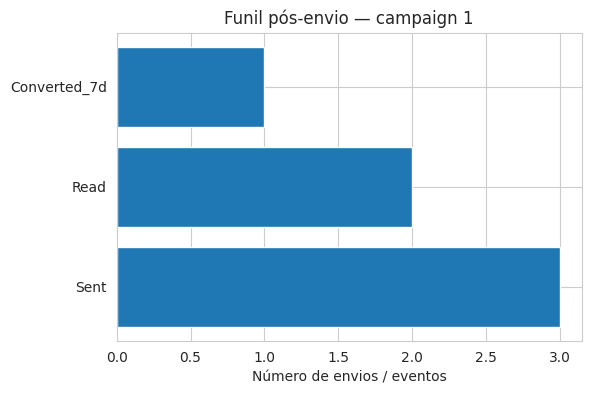

In [ ]:
#CÉLULA 20 FUNIL DE CAMPANHAS
# agrupa por campaignid (ou storeid)
f = cq.groupby('campaignid').agg(
    sent=('campaignid','count'),
    read=('is_read','sum')
).reset_index()
# juntar conversões (conv_7d ou conv_30d) a partir de cq/ordens
conv = cq.groupby('campaignid')['conv_7d'].sum().reset_index()
f = f.merge(conv, on='campaignid', how='left').fillna(0)

# exemplo: plot funnel simples para uma campanha específica
cid = f['campaignid'].iloc[0]
row = f[f['campaignid']==cid].iloc[0]
stages = ['Sent','Read','Converted_7d']
values = [row['sent'], row['read'], row['conv_7d']]

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.barh(stages, values)
plt.title(f'Funil pós-envio — campaign {cid}')
plt.xlabel('Número de envios / eventos')
plt.show()


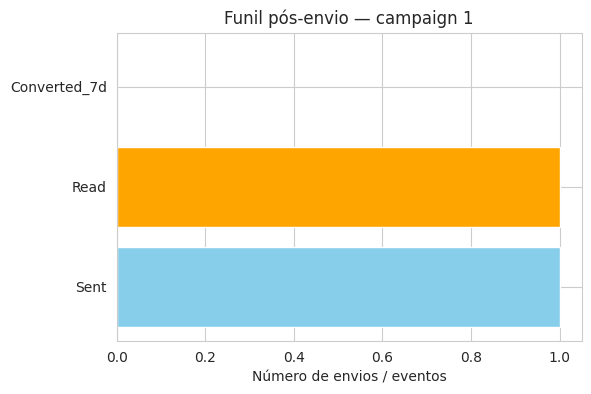

In [ ]:
import matplotlib.pyplot as plt

# agrupa por campanha
funnel = cq.groupby('campaign_id').agg(
    sent=('cq_id','count'),
    read=('is_read','sum'),
    converted=('conv_7d','sum')   # soma os envios com conversão
).reset_index()

# exemplo: plot funil para a primeira campanha
cid = funnel['campaign_id'].iloc[0]
row = funnel[funnel['campaign_id']==cid].iloc[0]
stages = ['Sent','Read','Converted_7d']
values = [row['sent'], row['read'], row['converted']]

plt.figure(figsize=(6,4))
plt.barh(stages, values, color=['skyblue','orange','green'])
plt.title(f'Funil pós-envio — campaign {cid}')
plt.xlabel('Número de envios / eventos')
plt.show()


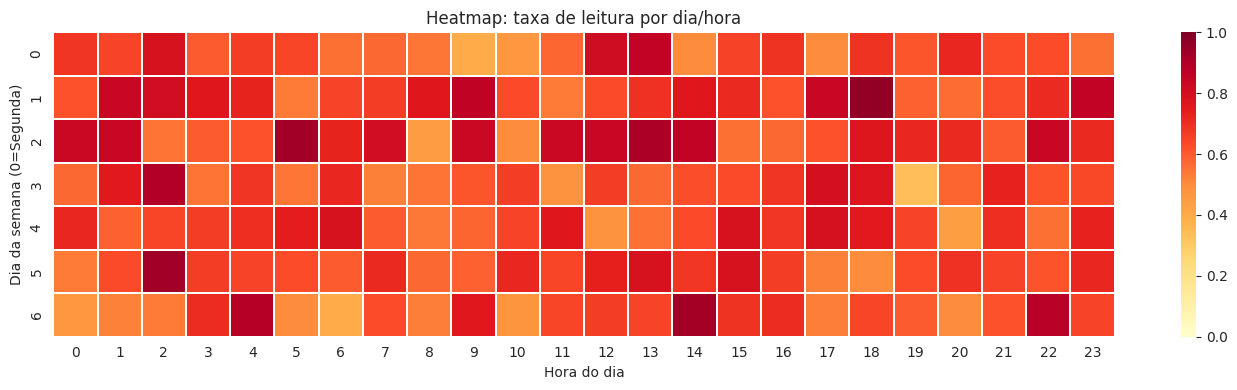

In [ ]:
# Célula 24: Heatmap hora x dia
if cq['sent_at'].notna().sum() == 0:
    print("Nenhuma data send_at válida encontrada.")
else:
    df_time = cq[cq['sent_at'].notna()].copy()
    df_time['hour'] = df_time['sent_at'].dt.hour
    df_time['dow'] = df_time['sent_at'].dt.dayofweek
    pivot = df_time.groupby(['dow','hour']).agg(read_rate=('is_read','mean')).reset_index().pivot(index='dow',columns='hour',values='read_rate').fillna(0)
    plt.figure(figsize=(14,4))
    sns.heatmap(pivot, cmap='YlOrRd', vmin=0, vmax=1, linewidths=0.2)
    plt.xlabel('Hora do dia')
    plt.ylabel('Dia da semana (0=Segunda)')
    plt.title('Heatmap: taxa de leitura por dia/hora')
    plt.tight_layout()
    plt.show()


In [ ]:
# Célula 25: Cohort / retention
first_sent = cq[cq['sent_at'].notna()].groupby('customer_id')['sent_at'].min().rename('first_sent').reset_index()
orders_with_first = orders.merge(first_sent, on='customer_id', how='inner')
orders_with_first['days_after_first_sent'] = (orders_with_first['createdAt'] - orders_with_first['first_sent']).dt.days

retention = {}
for d in (7,30,60):
    bought = orders_with_first[(orders_with_first['days_after_first_sent'] > 0) & (orders_with_first['days_after_first_sent'] <= d)]
    pct = bought['customer_id'].nunique() / (first_sent['customer_id'].nunique() or 1)
    retention[d] = pct
print("Retention:", {k:f"{v:.2%}" for k,v in retention.items()})

# cohort pivot (visual)
orders_with_first['cohort_month'] = orders_with_first['first_sent'].dt.to_period('M')
orders_with_first['order_month'] = orders_with_first['createdAt'].dt.to_period('M')
cohort = orders_with_first.groupby(['cohort_month','order_month']).agg(customers=('customer_id','nunique')).reset_index()
cohort_pivot = cohort.pivot(index='cohort_month',columns='order_month',values='customers').fillna(0)
display(cohort_pivot.head())


Retention: {7: '3.75%', 30: '15.33%', 60: '27.95%'}


order_month,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07,2025-08,2025-09
cohort_month,,,,,,,,,,,,,
2024-09,30.0,40.0,32.0,38.0,47.0,34.0,33.0,29.0,27.0,34.0,49.0,39.0,5.0
2024-10,29.0,28.0,26.0,34.0,30.0,30.0,30.0,23.0,29.0,33.0,31.0,34.0,1.0
2024-11,17.0,26.0,18.0,27.0,21.0,23.0,27.0,21.0,31.0,21.0,24.0,19.0,1.0
2024-12,21.0,13.0,20.0,15.0,18.0,19.0,18.0,19.0,18.0,14.0,17.0,22.0,1.0
2025-01,10.0,10.0,14.0,17.0,9.0,7.0,12.0,9.0,9.0,7.0,13.0,10.0,0.0


In [ ]:
# Célula 26: Scatter Real vs Previsto
# Se você já tem um DataFrame preds, basta executar essa célula.
# preds deve ter: ['customer_id','campaign_id','y_true','y_pred']

if 'preds' in globals():
    preds_local = preds.copy()
    plt.figure(figsize=(6,6))
    plt.scatter(preds_local['y_true'], preds_local['y_pred'], alpha=0.5)
    m = min(preds_local[['y_true','y_pred']].min().min(), 0)
    M = preds_local[['y_true','y_pred']].max().max()
    plt.plot([m,M],[m,M],'r--')
    plt.xlabel('Real')
    plt.ylabel('Previsto')
    plt.title('Real vs Previsto')
    plt.grid(True)
    plt.show()
    errs = preds_local.assign(abs_err=(preds_local['y_true']-preds_local['y_pred']).abs()).sort_values('abs_err',ascending=False)
    display(errs.head(10))
else:
    print("Não achei 'preds'. Gere preds = pd.DataFrame([...]) com colunas ['customer_id','campaign_id','y_true','y_pred'] e reexecute.")


Não achei 'preds'. Gere preds = pd.DataFrame([...]) com colunas ['customer_id','campaign_id','y_true','y_pred'] e reexecute.


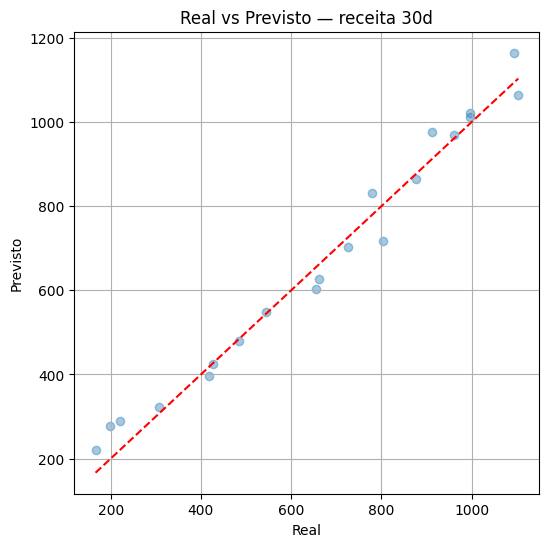

MAE: 36.793141142236095
R²: 0.9768872080857119

Top 10 maiores erros:


,y_true,y_pred,abs_err
53,803.410340,716.855862,86.554479
33,197.535520,277.471639,79.936120
90,1093.563827,1164.992240,71.428413
18,221.435458,288.324912,66.889454
44,911.402005,975.933794,64.531789
22,166.359453,220.169397,53.809944
4,655.041120,602.964443,52.076677
12,779.210693,830.882546,51.671853
77,1103.550523,1064.561950,38.988573
31,662.389270,628.041378,34.347893


In [ ]:
# Célula 26: LinearRegression Real vs Previsto
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Exemplo: dataset artificial
np.random.seed(42)
n = 100
X = pd.DataFrame({
    'is_read': np.random.randint(0,2,n),
    'conv_7d': np.random.rand(n)
})
y = 1000 * X['conv_7d'] + 200 * X['is_read'] + np.random.randn(n)*50  # receita simulada

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo simples
model = LinearRegression()
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)

# Plot: Real vs Previsto
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Real')
plt.ylabel('Previsto')
plt.title('Real vs Previsto — receita 30d')
plt.grid(True)
plt.show()

# Métricas + Top 10 erros
errs = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred_test})
errs['abs_err'] = (errs['y_true'] - errs['y_pred']).abs()
print('MAE:', mean_absolute_error(y_test, y_pred_test))
print('R²:', r2_score(y_test, y_pred_test))
print('\nTop 10 maiores erros:')
display(errs.sort_values('abs_err', ascending=False).head(10))


In [ ]:
# Exemplo: gerar preds a partir de sklearn
# model.fit(...) feito em outra célula; X_test e y_test disponíveis
y_pred = model.predict(X_test)
preds = pd.DataFrame({
    'customer_id': X_test.get('customer_id', range(len(y_test))),
    'campaign_id': X_test.get('campaign_id', np.nan),
    'y_true': y_test,
    'y_pred': y_pred
})


NameError: name 'model' is not defined

In [ ]:
# Célula 7: calibração (execute se tiver probs e y_test)
if 'probs' in globals() and 'y_test' in globals():
    plt.figure(figsize=(6,4))
    plt.hist(probs, bins=30, edgecolor='black')
    plt.title('Histograma de probabilidades (conv_7d)')
    plt.xlabel('Probabilidade prevista')
    plt.ylabel('Count')
    plt.tight_layout(); plt.show()

    prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10)
    plt.figure(figsize=(6,6))
    plt.plot(prob_pred, prob_true, marker='o', label='Modelo')
    plt.plot([0,1],[0,1],'r--', label='Perfeito')
    plt.xlabel('Probabilidade prevista')
    plt.ylabel('Probabilidade real observada')
    plt.title('Curva de calibração — conv_7d')
    plt.legend(); plt.grid(True); plt.show()
else:
    print("Não encontrei 'probs' e/ou 'y_test'. Rode seu classificador e defina essas variáveis.")


Não encontrei 'probs' e/ou 'y_test'. Rode seu classificador e defina essas variáveis.


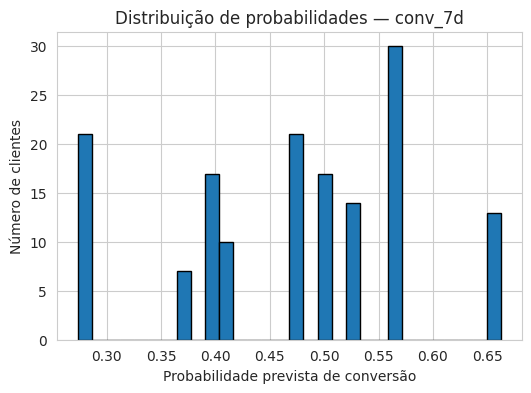

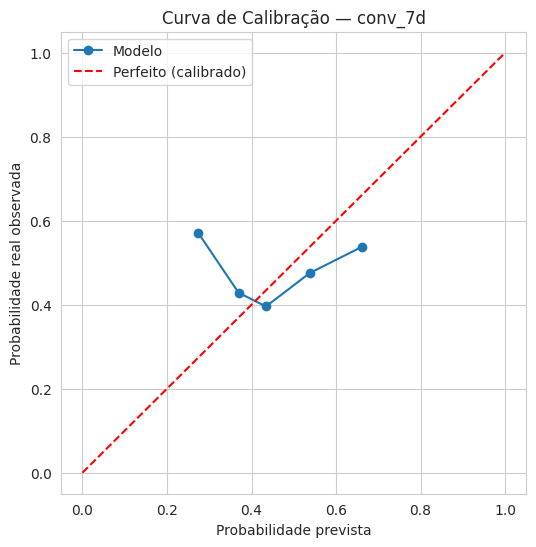

In [ ]:
#CÉLULA 27 DISTRIBUIÇÃO DE PROBABILIDADES E CURVA DE CALIBRAÇÂP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve

# Exemplo com base similar
np.random.seed(42)
n = 500
cq = pd.DataFrame({
    'is_read': np.random.randint(0,2,n),
    'campaignid': np.random.randint(1,6,n),
    'conv_7d': np.random.randint(0,2,n)
})

# Separar variáveis
X = cq[['is_read', 'campaignid']]
y = cq['conv_7d']

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modelo simples
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Gerar probabilidades de conversão (classe positiva)
probs = model.predict_proba(X_test)[:, 1]

# --- HISTOGRAMA DE PROBABILIDADES ---
plt.figure(figsize=(6,4))
plt.hist(probs, bins=30, edgecolor='black')
plt.title('Distribuição de probabilidades — conv_7d')
plt.xlabel('Probabilidade prevista de conversão')
plt.ylabel('Número de clientes')
plt.show()

# --- CURVA DE CALIBRAÇÃO ---
prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10)

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Modelo')
plt.plot([0,1],[0,1],'r--', label='Perfeito (calibrado)')
plt.title('Curva de Calibração — conv_7d')
plt.xlabel('Probabilidade prevista')
plt.ylabel('Probabilidade real observada')
plt.legend()
plt.grid(True)
plt.show()


Resumo médio dos segmentos:
      hist_avg_order  hist_sum_order  num_orders
seg                                            
0            3729.0          5100.0         1.0
1               0.0             0.0         0.0
2            6781.0         17539.0         3.0
3             686.0           773.0         1.0


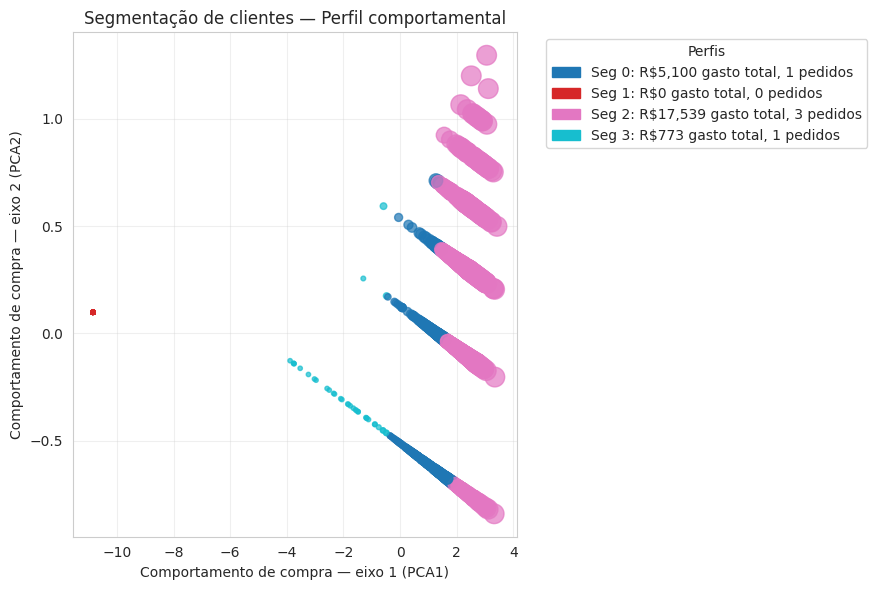

In [ ]:
# Célula 28: segmentação KMeans + PCA (executar)
# usar 'customers' criado na Célula 2

import matplotlib.patches as mpatches

# Resumo dos clusters
seg_summary = customers.groupby('seg')[feat_cols].mean().round(0)
print("Resumo médio dos segmentos:\n", seg_summary)

# cria rótulos automáticos para os clusters (você pode editar depois)
labels = {
    i: f"Seg {i}: R${row['hist_sum_order']:,.0f} gasto total, {row['num_orders']:.0f} pedidos"
    for i, row in seg_summary.iterrows()
}

# scatter plot mais explicativo
plt.figure(figsize=(9,6))
scatter = plt.scatter(
    customers['pca1'], customers['pca2'],
    c=customers['seg'], cmap='tab10',
    s=np.clip(customers['hist_sum_order']/100, 10, 200),
    alpha=0.7
)
plt.xlabel('Comportamento de compra — eixo 1 (PCA1)')
plt.ylabel('Comportamento de compra — eixo 2 (PCA2)')
plt.title('Segmentação de clientes — Perfil comportamental')

# legenda customizada
handles = [mpatches.Patch(color=scatter.cmap(scatter.norm(i)), label=labels[i]) for i in labels]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', title='Perfis')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
